# Project Description

The task is to find the best place for a new well for the OilyGiant mining company.

**Steps to choose the location:**

1. Collect the oil well parameters in the selected region: oil quality and volume of reserves;

2. Build a model for predicting the volume of reserves in the new wells; 

3. Pick the oil wells with the highest estimated values;

4. Pick the region with the highest total profit for the selected oil wells.

**Data description:**

1. Geological exploration data for the three regions are stored in files:

    *geo_data_0.csv, geo_data_1.csv ,geo_data_2.csv* 

2. Columns in the datasets

    *id* — unique oil well identifier

    *f0, f1, f2* — three features of points (their specific meaning is unimportant, but the features themselves are significant)

    *product* — volume of reserves in the oil well (thousand barrels)

**Conditions:**

1. Only *linear regression* is suitable for model training (the rest are not sufficiently predictable).

2. When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.

3. The budget for oil well development is *100 USD million*.

4. One barrel of raw materials brings 4.5 USD of revenue. The revenue from one unit of product is *4,500 dollars* (volume of reserves is in thousand barrels).

5. After the risk evaluation, keep only the regions with the risk of losses *lower than 2.5%*. From the ones that fit the criteria, the region with the highest average profit should be selected.

## 1. Data Processing

In [1]:
# Necessary Packages 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy.random import RandomState
state = RandomState(12345)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Open the datasets
try:
    data_1 = pd.read_csv('geo_data_0.csv')
    data_2 = pd.read_csv('geo_data_1.csv')
    data_3 = pd.read_csv('geo_data_2.csv')
except:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# Study the datasets
for data,i in zip([data_1, data_2, data_3], range(3)):
    print('Region', i + 1)
    print()
    print(data.info())
    print()
    print(data.describe())
    print()
    print('Number of duplicates:',data.duplicated().sum())
    print()

Region 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331  

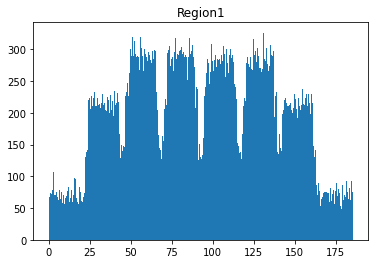

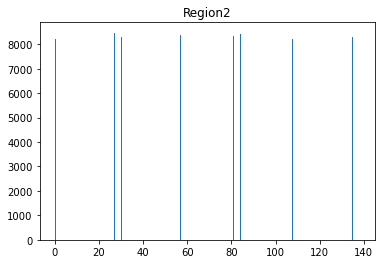

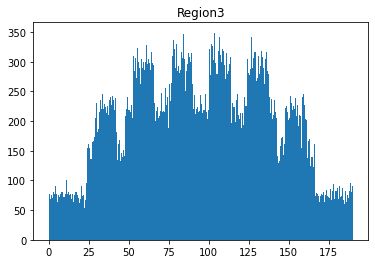

In [4]:
# Target future
for data,i in zip([data_1, data_2, data_3], range(3)):
    plt.hist(data['product'], bins = 500)
    plt.title('Region' + str(i + 1))
    plt.show()

**Descriptions:**

1. Each of the datasets has 4 columns, except the *id*, other ones are nummeric and can be directly used as features and target in machine learning models.

2. No duplicates are spotted in the datasets.

3. There is no missing value in all the datasets.

4. The distribution of target feature of region 2 is very distinct and different from those of the other 2 regions. The distributions of the target feature in region 1 and 3 are more close to normal distribution.

## 2. Train and test the model for each region

In [5]:
data_all = [
    data_1.drop('id', axis=1),
    data_2.drop('id', axis=1),
    data_3.drop('id', axis=1),
]

In [6]:
state = np.random.RandomState(12345)

samples_target = []
samples_predictions = []
for region in range(len(data_all)):
    data = data_all[region]
    features = data.drop('product', axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=state)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    samples_target.append(target_valid.reset_index(drop=True))
    samples_predictions.append(pd.Series(predictions))
    
    mean_product = target.mean()
    model_rmse = mean_squared_error(target_valid, predictions)**0.5
    
    print("-- Region", region + 1, "--")
    print("Average amount of product =", mean_product)
    print("RMSE of the model:", model_rmse)
    print("Score:", model.score())
    print()

-- Region 1 --
Average amount of product = 92.49999999999976
RMSE of the model: 37.5794217150813

-- Region 2 --
Average amount of product = 68.82500000002561
RMSE of the model: 0.8897367737680641

-- Region 3 --
Average amount of product = 95.00000000000041
RMSE of the model: 39.958042459521614



**Description:**

1. The linear model fits the dataset of region 2 much better than the other 2 regions, it has the lowerst RMSE value.

2. The predicted mean of region 3 is the highest.

## 3. Profit calculation

In [7]:
BUDGET = 100000000
POINTS_PER_BUDGET = 200

PRODUCT_PRICE = 4500


def profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected_points = target[predictions_sorted.index][:POINTS_PER_BUDGET]
    product = selected_points.sum()
    revenue = product * PRODUCT_PRICE
    cost = BUDGET
    return revenue - cost

In [8]:
for j in range(3):
    profit_ = profit(samples_target[j], samples_predictions[j])
    print('Region {:}'.format(j + 1))
    print('Profit: {:.2f} Million $'.format(profit_ / 1000000))
    print()

Region 1
Profit: 33.21 Million $

Region 2
Profit: 24.15 Million $

Region 3
Profit: 25.40 Million $



**Descriptions:**

1. The volume (111 thousand barrels) of reserves sufficient for developing a new well without losses is much higher than the average volumnes in the 3 regions.

2. Except region 1, the plan to open 200 wells in the other 2 regions are likely to suffer from loss.

## 4. Calculate risks and profit for each region

In [9]:
SAMPLE_SIZE = 500
BOOTSTRAP_SIZE = 1000

for region in range(3):
    target = samples_target[region]
    predictions = samples_predictions[region]
    
    profit_values = []
    for i in range(BOOTSTRAP_SIZE):
        target_sample = target.sample(SAMPLE_SIZE, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit_values.append(profit(target_sample, predictions_sample))
    profit_values = pd.Series(profit_values)
        
    mean_profit = profit_values.mean() / 1000000
    confidence_interval = (profit_values.quantile(0.025) / 1000000, profit_values.quantile(0.975) / 100000)
    negative_profit_chance = (profit_values < 0).mean()
    
    print("-- Region", region + 1, "--")
    print("Average profit =", mean_profit)
    print("95% confidence interval:", confidence_interval)
    print("Risk of loss:", negative_profit_chance * 100, "%")
    print()

-- Region 1 --
Average profit = 4.238972379169054
95% confidence interval: (-0.7618781389036369, 95.78465319517836)
Risk of loss: 4.8 %

-- Region 2 --
Average profit = 5.1325669891726085
95% confidence interval: (1.0806689523396174, 92.85744392324952)
Risk of loss: 0.6 %

-- Region 3 --
Average profit = 3.811203595759016
95% confidence interval: (-1.428006300878686, 89.33805657503996)
Risk of loss: 7.3999999999999995 %



**Descriptions:**

According to the result above, region 2 has lowest possbility to generate a negative profit among all regions, and the predicted average profit of region 2 is also the highest. 

## 5. Conclusions:

1. Linear regression model fits well only with the dataset of region 2, since it has a lowest RMSE value.

2. Region 2 should be chosen to develop new wells since it is the region that is most likely to generate a positive profit. 

3. Due to the low score of our machine learning model, the conclusions above might have a serious flaw in its accuracy. 